## Capstone - Milestone 2: Initial Models

After analyzing the diaper manufacturing process and cleaning/exploring our data, it is now time to build a few baseline models that can help us set benchmarks for our predictions before moving to more complex models. These initial models can also potentially inform us further about the relationships within our data set. In Milestone 1, we did the following:
- Joined label and feature data
- Imputed missing values
- Removed unnecessary columns
- Performed feature engineering
- Checked and solved for class imbalance
- Applied feature selection methods to reduce data dimensionality

It was important to do these steps before modeling because we had a relatively sparse data set. Most of the features did not show significance in helping us predict whether a product was faulty and could therefore be removed. We did this by using a mutual information classification along with a recursive feature elimination to bring down our feature set to just 50 features. 

With these 50 features, we can now build our baseline model. In this Milestone, we will build the following models:
- Decision Tree
- Random Forest
- Support Vector Machine

In additon to building these models, we will be assessing a few performance metrics in particular. Due to the extreme class imbalance, we will want to optimize for precision and recall, rather than only looking at accuracy. This is because our goal is identify faulty products (positives) in the manufacturing supply chain, which only make up a very small percent of all manufactured products. Using precision and recall can help us understand whether our model is able to detect these faulty products accurately.

### Feature Set

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

data = np.loadtxt('data/secom.data')

# Data here is a numpy array (2 dimensional)
print(data.shape)

(1567, 590)


In [159]:
secom = pd.DataFrame(data)
secom.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


### Labels

In [160]:
#read in labels data

with open('data/secom_labels.data', 'r') as f:
    labels = f.readlines()
    
print(labels[:3])

['-1 "19/07/2008 11:55:00"\n', '-1 "19/07/2008 12:32:00"\n', '1 "19/07/2008 13:17:00"\n']


The data set needs to be cleaned. We'll start by splitting each value in the list using the spaces, then replacing the double quotes with a single quote and stripping any other unnecessary spaces. 

In [161]:
#split by spaces

labels = [label.split(' ') for label in labels]

In [162]:
#replace double quotes and strip extra spaces

labels = [[entry.strip().replace('"', '') for entry in label] for label in labels]

In [163]:
#convert to dataframe

labels = pd.DataFrame(labels, columns = ['target', 'date', 'time'])
labels.head()

,target,date,time
0,-1,19/07/2008,11:55:00
1,-1,19/07/2008,12:32:00
2,1,19/07/2008,13:17:00
3,-1,19/07/2008,14:43:00
4,-1,19/07/2008,15:22:00


We now have a clean data frame of the three columns from the labels data set. Let's join this to the feature set.

In [164]:
#join labels to secom dataset

df = secom.join(labels)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,583,584,585,586,587,588,589,target,date,time
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,19/07/2008,11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,19/07/2008,12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008,13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008,14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008,15:22:00


### Data Cleaning & Feature Engineering

With our data set in one piece, we can now focus on the null values in the data set. Since we are looking to find the most predictive features, we will likely not find signal in columns with an excessive number of missing values. Let's drop columns that have > 20% of the 1567 observations as null values, as we're highly unlikely to find any of these to be useful in the model.

In [165]:
#dropping columns with over 20% null values
drop_na = list(df.loc[:,df.isna().sum() > (df.count())*(1/5)].columns)
df.drop(drop_na, axis=1, inplace=True)

In [166]:
#delete date, time features

del[df['date']]
del[df['time']]

In [167]:
df['target'] = df['target'].replace('-1', 0)

In [168]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,target
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


We're now ready to split our data set into a train, test, and validation set. Given that we do not have many observations to train on, we will give 80% of the entire data set to our train set and then 10% each to our validation and test sets.

In [169]:
#drop target from X

X = df.drop(['target'], axis = 1)
y = df['target'].astype('int64')

In [170]:
#split into 80-20 train-val/test
#50-50 val/test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.50, random_state = 1)

In [171]:
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [172]:
print('X train shape: {}'.format(X_train.shape))
print('X validation shape: {}'.format(X_valid.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (1253, 550)
X validation shape: (157, 550)
X test shape: (157, 550)


Before doing any feature selection, we must do two things. First, we still have to impute missing values in each of our data sets. Second, we should make sure to standardize the numeric features in our data. Measurements in our data are likely to have different units and scales, so to account for this, we must transform these features for them to be on the same scale. This is important when we run certain algorithms such as Support Vector Machines.

In [173]:
#fill missing values with the mean of the train set

for column in X_train.columns:
    X_train[column].fillna(X_train[column].mean(), inplace=True)
    X_valid[column].fillna(X_train[column].mean(), inplace=True)
    X_test[column].fillna(X_train[column].mean(), inplace=True)

In [174]:
#initialize standardscaler
#fit numeric columns

from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(X_train)
X_train = pd.DataFrame(znormalizer.transform(X_train), columns = X_train.columns)
X_valid = pd.DataFrame(znormalizer.transform(X_valid), columns = X_valid.columns)
X_test = pd.DataFrame(znormalizer.transform(X_test), columns = X_test.columns)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,576,577,582,583,584,585,586,587,588,589
0,-0.958601,0.927555,-0.213206,2.119234,-0.040224,0.0,-2.270271,0.145725,-0.562111,0.600802,...,4.793848,6.258281,-0.699295,0.051608,-0.089278,0.051607,2.667230,0.127941,-0.080762,-0.716431
1,-1.059148,0.038292,-2.912957,0.330101,-0.057009,0.0,-0.367259,0.535636,-0.241648,-0.671046,...,-0.226081,0.318446,0.399258,-0.384719,-0.355759,-0.371223,0.025725,-0.256531,-0.283599,-0.372816
2,-1.433404,0.754126,0.100630,2.788137,-0.053570,0.0,-2.381693,0.183458,-0.251034,-0.573212,...,-0.254379,0.291199,-0.439112,-0.006218,0.056075,-0.005771,-0.897211,0.204835,0.257299,0.801493
3,0.462736,-0.761869,0.418952,-0.654294,-0.066859,0.0,0.488114,-0.105831,1.316421,0.013795,...,-0.233396,-0.689358,-1.046207,-0.248038,-0.186181,-0.233365,-0.411874,1.665826,1.643351,0.956293
4,-0.299742,1.183426,0.760062,0.772441,-0.046513,0.0,-0.689508,0.271502,1.197086,-1.740703,...,-0.211346,-0.467898,1.121990,-0.016732,-0.040827,-0.021685,-0.395961,-0.377364,-0.486436,-0.228242


### Dealing with Class Imbalance

We need to check the distribution of our target variable before getting to feature selection and modeling. An imbalanced target can lead to biases in our predictions towards the majority class. 

In our case, we are dealing with defects in the manufacturing process. It's likely that the positive cases in such a problem are very low in proportion to the negative ones. Because we are more interested in the model identifying the minority class (when there is a defect in the manufacturing process), we need to pay special attention to the class imbalance problem in this data set. With a very small number of positive cases in the data set, the model we choose will likely find it challenging to predict the minority class in the future because of the lack of historical examples we are feeding it.

Before we apply any methods to solve for class imbalance, let's look at the distribution of the target feature.

In [175]:
y_train.value_counts()

0    1169
1      84
Name: target, dtype: int64

This is clearly a very imbalanced data set with less than 10% of the cases as positive (class 1). To balance the classes, we can use SMOTE to over sample the minority class (in this case the defects). SMOTE will balance the number of observations in each class by manufacturing synthetic data using a kmeans clustering algorithm.

SMOTE is a widely used approach to synthesizing new examples in a data set. It's useful to us because the algorithm selects a minority class at random, find its k nearest minority class neighbor, and then create a synthetic instance by choosing one of the k nearest neighbors at random to form a line segment in the feature space. After we apply SMOTE, we should see a balanced set of positive and negative classes.

In [176]:
#set number of k nearest neighbors
#fit on training data

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0, k_neighbors = 7)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [177]:
#check class distribution

y_train.value_counts()

1    1169
0    1169
Name: target, dtype: int64

Looks like SMOTE did its job. We can now get into feature selection. 

### Feature Selection

We're going to start by doing a simple mutual information classification to give us a subset of important features to use in our predictive model. The reason for using mutual information is that it provides the important statistical dependencies that exist in our data set in the context of our target variable.

The definition for mutual information is provided below:

*A quantity called mutual information measures the amount of information one can obtain from one random variable given another*

Running a mutual information classification is an efficient way of selecting a set of features that can explain the target variable from a larger data set. After running this, we can use the subset of features chosen by the mutual information classification and run stepwise feature selection to iteratively select a smaller set of predictive features for our model.

Before we run our classification, we need to reset the feature names, as mutual information outputs the column index. For us to easily subset on what the algorithm selects, we need to order our feature names.

In [178]:
#reset feature names to order

cols = [i for i in range(0, 550)]
X_train.columns = cols
X_valid.columns = cols
X_test.columns = cols
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,540,541,542,543,544,545,546,547,548,549
0,-0.958601,0.927555,-0.213206,2.119234,-0.040224,0.0,-2.270271,0.145725,-0.562111,0.600802,...,4.793848,6.258281,-0.699295,0.051608,-0.089278,0.051607,2.667230,0.127941,-0.080762,-0.716431
1,-1.059148,0.038292,-2.912957,0.330101,-0.057009,0.0,-0.367259,0.535636,-0.241648,-0.671046,...,-0.226081,0.318446,0.399258,-0.384719,-0.355759,-0.371223,0.025725,-0.256531,-0.283599,-0.372816
2,-1.433404,0.754126,0.100630,2.788137,-0.053570,0.0,-2.381693,0.183458,-0.251034,-0.573212,...,-0.254379,0.291199,-0.439112,-0.006218,0.056075,-0.005771,-0.897211,0.204835,0.257299,0.801493
3,0.462736,-0.761869,0.418952,-0.654294,-0.066859,0.0,0.488114,-0.105831,1.316421,0.013795,...,-0.233396,-0.689358,-1.046207,-0.248038,-0.186181,-0.233365,-0.411874,1.665826,1.643351,0.956293
4,-0.299742,1.183426,0.760062,0.772441,-0.046513,0.0,-0.689508,0.271502,1.197086,-1.740703,...,-0.211346,-0.467898,1.121990,-0.016732,-0.040827,-0.021685,-0.395961,-0.377364,-0.486436,-0.228242


In [179]:
#run classification
#convert output to list and show 100 highest mutual information features

from sklearn.feature_selection import mutual_info_classif
import heapq

mi_score = mutual_info_classif(np.array(X_train), y_train)

mi = mi_score.tolist()
num = 125

m = heapq.nlargest(num, enumerate(mi), key = lambda mi: mi[1])

In [180]:
#see results

m

[(136, 0.4638890422180948),
 (544, 0.45908196976869786),
 (339, 0.4577372839224392),
 (148, 0.4574705151386389),
 (117, 0.4504254699048873),
 (157, 0.44873861106499247),
 (357, 0.44796422821464543),
 (124, 0.4449264826463024),
 (158, 0.4400701953874335),
 (229, 0.4387732977352048),
 (210, 0.4346024809952205),
 (101, 0.43423278825224276),
 (114, 0.43403871558015394),
 (358, 0.43327610800126415),
 (116, 0.43098929604214287),
 (369, 0.42715437776014364),
 (7, 0.4269600530799169),
 (349, 0.42683886387684633),
 (264, 0.4264440231248807),
 (347, 0.4242306349678815),
 (228, 0.4178680583090011),
 (341, 0.4143332498346821),
 (102, 0.41290963985491014),
 (128, 0.4124332940469868),
 (122, 0.4064570799039715),
 (346, 0.40377054406710644),
 (348, 0.4003284609961819),
 (274, 0.39995989067156246),
 (548, 0.39895649634268904),
 (109, 0.3984159346690537),
 (55, 0.39720793639176555),
 (89, 0.3962080917376465),
 (97, 0.39556766853580494),
 (29, 0.3925176965354993),
 (268, 0.3892862894032456),
 (103, 0.38

We now have the 125 features with the highest mutual information. We can use these features to subset our original data set before using a step wise feature selection method called recursive feature elimination (RFE).

Before moving to RFE, let's reset our feature names again.

In [181]:
#use feature names to subset original dataframe
X_col = [i[0] for i in m]
X_train = X_train[X_col]

In [182]:
X_valid = X_valid[X_col]
X_test = X_test[X_col]

In [183]:
cols = [i for i in range(0, 125)]
X_train.columns = cols
X_valid.columns = cols
X_test.columns = cols
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,-0.823328,-0.089278,0.203201,-0.203907,-0.302392,-0.166872,0.002389,0.704207,0.742367,-0.069668,...,-0.094124,-0.118287,-0.786655,-1.211436,0.127941,-1.191871,0.497086,-0.484273,-0.027531,0.099967
1,0.279585,-0.355759,-0.386447,-0.237469,-0.744683,-0.608406,1.123169,-1.153850,-0.358176,0.075227,...,0.048701,0.990386,-0.168723,0.361430,-0.256531,0.429895,-1.085006,-1.042203,0.544045,0.214363
2,-2.083800,0.056075,0.006652,-0.229079,-2.071555,1.246035,0.375982,0.571488,1.685691,-0.576801,...,-0.522597,1.290749,-0.617990,-1.025075,0.204835,-0.981764,-0.684255,1.605176,-0.408390,0.031329
3,-0.193092,-0.186181,0.596300,-0.212298,-0.390850,-0.608406,0.749576,0.969643,0.113485,-0.721696,...,3.461252,1.381205,-0.185665,0.885292,1.665826,0.870354,-0.433351,0.132240,1.158870,0.588056
4,-0.980887,-0.040827,1.185947,-0.237469,-1.275432,0.098048,0.375982,-0.578737,-0.200956,-0.214563,...,-0.050324,0.855861,-0.052549,-0.107356,-0.377364,-0.051601,1.494896,-1.572237,0.434010,0.107593


We're going to use recursive feature selection (RFE) with a decision tree to choose the best features from our subset dataframe, optimizing for accuracy. The algorithm will offer importance scores, ranking the predictors from most important to least. RFE is a wrapper style feature selection method that discards less important features and repeatedly refits the model until the specified set of features remain. We will choose 50 of the 100 features that are the most predictive of our target before moving onto modeling.

In [184]:
# select 50 independent features, removing 1 feature at a time
# import decision tree classifier
# Recursive Feature Elimination
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE 

estimator = DecisionTreeClassifier()

back_selector = RFE(estimator, 50, step = 1)
back_selector = back_selector.fit(X_train, y_train)

C:\Users\kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


We can now output the results and see which features RFE chose for us.

In [185]:
#show features selected by RFE

back_features = pd.DataFrame(back_selector.support_)

sel_back = back_features[0].loc[back_features[0] == True]
sel_back

1      True
2      True
5      True
6      True
7      True
10     True
12     True
13     True
14     True
18     True
21     True
23     True
24     True
26     True
27     True
31     True
36     True
39     True
40     True
46     True
49     True
53     True
54     True
56     True
59     True
63     True
66     True
69     True
71     True
72     True
73     True
76     True
88     True
89     True
91     True
92     True
94     True
97     True
101    True
102    True
103    True
109    True
110    True
111    True
112    True
113    True
117    True
119    True
121    True
123    True
Name: 0, dtype: bool

In [186]:
#subset on 50 most important features
#display new data frame
X_train = X_train[sel_back.index.tolist()]
X_valid = X_valid[sel_back.index.tolist()]
X_test = X_test[sel_back.index.tolist()]
X_train.head()

,1,2,5,6,7,10,12,13,14,18,...,103,109,110,111,112,113,117,119,121,123
0,-0.089278,0.203201,-0.166872,0.002389,0.704207,0.326860,0.344013,0.055307,0.097456,-0.620863,...,0.136093,0.134134,-0.078126,-0.400364,-1.386148,0.313557,-0.786655,0.127941,0.497086,-0.027531
1,-0.355759,-0.386447,-0.608406,1.123169,-1.153850,-0.331345,-0.674042,0.504585,-0.273593,0.853775,...,0.582275,1.272236,0.000329,-0.640573,0.453855,0.189876,-0.168723,-0.256531,-1.085006,0.544045
2,0.056075,0.006652,1.246035,0.375982,0.571488,0.147350,-2.506541,-1.067890,-2.407124,-2.095501,...,-0.495425,1.090698,-0.188637,-0.790703,-1.363236,-0.080496,-0.617990,0.204835,-0.684255,-0.408390
3,-0.186181,0.596300,-0.608406,0.749576,0.969643,0.685881,-0.266820,-0.843250,-0.644642,0.558848,...,-0.188818,1.520105,-0.171654,-0.410373,0.741135,0.176933,-0.185665,1.665826,-0.433351,1.158870
4,-0.040827,1.185947,0.098048,0.375982,-0.578737,1.463760,-0.572237,0.504585,-0.366355,-0.915791,...,0.428971,0.560050,0.018083,-0.430390,-0.406223,0.017298,-0.052549,-0.377364,1.494896,0.434010


### Modeling

We are ready to begin modeling. We will begin by building a decision tree classifier before moving to random forest and SVM classifiers. The decision tree classifier will give us more intuition about the decision making within the model, where the most important splits are, and more information about the non linear relationships within the data set.

Below, we trained a classifier using a greedy approach to parameter tuning. We incremented the max leaf node parameter by 1 until performance dropped off before using the same approach on the minimum sample leaf and split parameters. This left us with the parameters shown in the code block below.

In [187]:
#train decision tree
#predict on train and val
#print accuracy on both

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtree = DecisionTreeClassifier(min_samples_leaf = 2, max_leaf_nodes = 11, 
                               min_samples_split = 2, class_weight = 'balanced').fit(X_train, y_train)

y_dtree_train = dtree.predict(X_train) 
y_dtree_valid = dtree.predict(X_valid) 

print("Decision Tree accuracy on training set: {:.1f}%".format(accuracy_score(y_train, y_dtree_train)*100))
print("Decision Tree accuracy on validation set: {:.1f}%".format(accuracy_score(y_valid, y_dtree_valid)*100))

Decision Tree accuracy on training set: 80.2%
Decision Tree accuracy on validation set: 84.1%


Surprisingly, our validation accuracy was higher than our accuracy on the training set. To understand what is happening under the hood, we need to visualize our decision tree and then look at the precision and recall to get a better sense of how the model is classifying the positive cases.

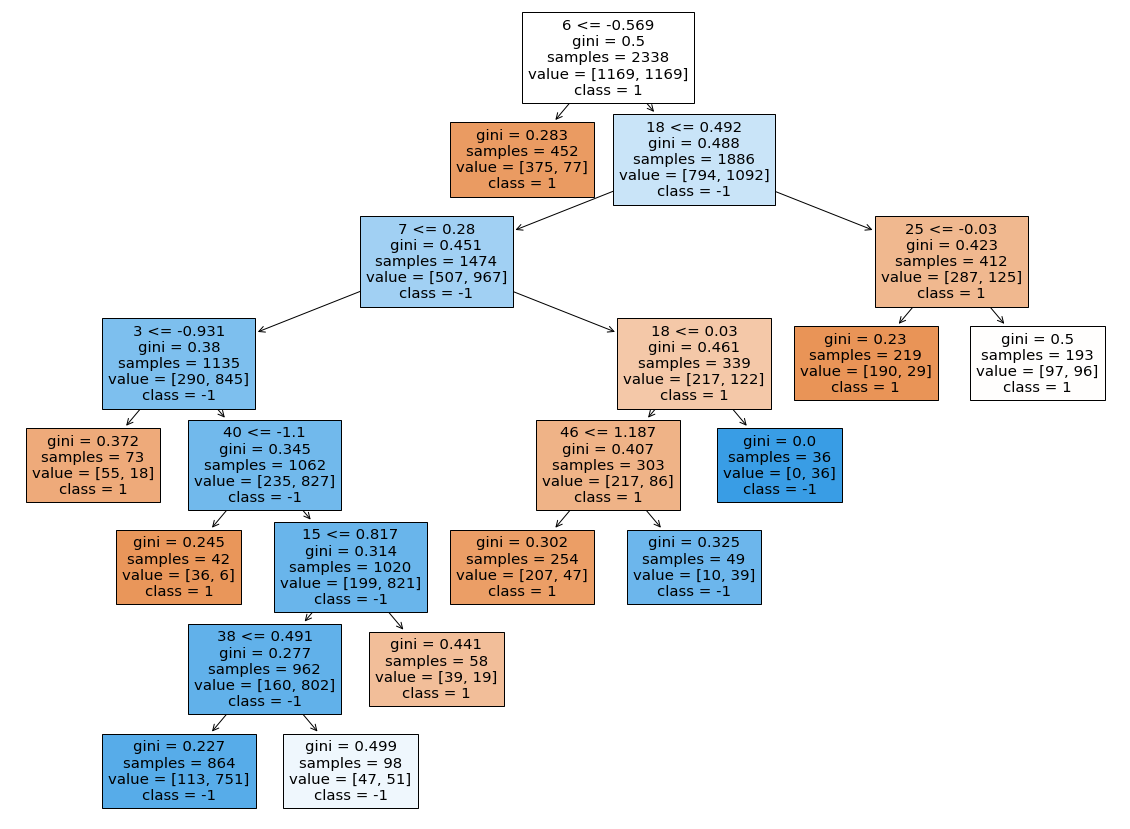

In [188]:
#plot decision tree

from sklearn import tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15)) 
tree.plot_tree(dtree,
               feature_names=X.columns,  
               class_names=['1', '-1'],
               filled=True);

To understand the decision tree, we begin with the root node. This classifier uses the gini coefficient to determine each split. Notice how at the root node, we can see the highest gini coefficient of any node in the tree. This means that the feature identified in the root node is the most important according to our model. From this node, the model divides the classes evenly. The left split becomes a leaf/terminal node, where no further splits are made indicating that the model has made a final decision on these particular observations. The right split sends the rest of the observations down a deep path to figuring out which class they stand in.

With this understanding, we can now move onto getting a precision and recall score from our model. The purpose of both metrics is to better understand how our model is classifying the positive class.

In [190]:
#print precision/recall for train-val

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_train = precision_score(y_train, y_dtree_train, pos_label = 1) * 100
precision_valid = precision_score(y_valid, y_dtree_valid, pos_label = 1) * 100
recall_train = recall_score(y_train, y_dtree_train, pos_label = 1) * 100
recall_valid = recall_score(y_valid, y_dtree_valid, pos_label = 1) * 100

print("Precision on training data: {:.1f}%.".format(precision_train))
print("Recall on training data: {:.1f}%.\n".format(recall_train))
print("Precision on validation data: {:.1f}%.".format(precision_valid))
print("Recall on validation data: {:.1f}%.".format(recall_valid))

Precision on training data: 83.8%.
Recall on training data: 75.0%.

Precision on validation data: 22.2%.
Recall on validation data: 60.0%.


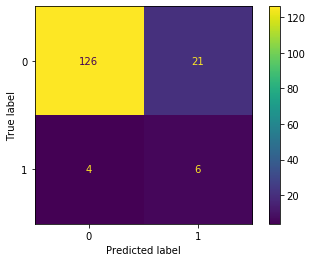

In [195]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(dtree, X_valid, y_valid);

The results above tell us that the model is over fitting to the training set. Both precision and recall, drop off considerably from train to validation. Notice how many false positives the decison tree has output. One part of this is likely due to the class imbalance in the data set. 

Let's implement a random forest next to see if we can get a more robust model. Random forest is far less likely to overfit because it uses many small decision trees rather than only one to make its predictions. We will begin with a grid search to choose the optimal parameters for the model. The code block below has been commented out due to run time.

In [197]:
#set parameter grid
#initialize rf regressor
#perform grid search - 2 cvs
#print best parameters

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [10, None],
#    'max_features': [5, 10],
#    'n_estimators': [1000, 1200]
#}

#rf = RandomForestRegressor()
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 2, n_jobs = -1, verbose = 2)

#grid_search.fit(X_train, y_train)
#grid_search.best_params_

We can now use the parameters specified by the grid search to train our random forest classifier.

In [198]:
#use optimal parameters from grid search
#run rf classifier

from sklearn.ensemble import RandomForestClassifier

hypers = {"n_estimators": 1200, "max_features": 10, "max_depth": None, 
          "min_samples_leaf": 2, "min_samples_split": 3}
clf_rf = RandomForestClassifier(random_state = 0, class_weight = 'balanced',
                                verbose = True, **hypers).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   15.4s finished


In [199]:
#predict on train-val
#print accuracy

y_hat_train_rf = clf_rf.predict(X_train)
y_hat_valid_rf = clf_rf.predict(X_valid)

acc_train_rf = accuracy_score(y_train, y_hat_train_rf)
acc_val_rf = accuracy_score(y_valid, y_hat_valid_rf)

print('Train set random forest accuracy: {:.2f}%'.format(acc_train_rf * 100))
print('Validation set random forest accuracy: {:.2f}%'.format(acc_val_rf * 100))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train set random forest accuracy: 100.00%
Validation set random forest accuracy: 94.90%


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.0s finished


We got much better accuracy on both the training and validation sets. We should expect a better recall and precision score as well, let's check.

In [201]:
#print precision/recall

precision_train_rf = precision_score(y_train, y_hat_train_rf, pos_label = 1) * 100
precision_valid_rf = precision_score(y_valid, y_hat_valid_rf, pos_label = 1) * 100
recall_train_rf = recall_score(y_train, y_hat_train_rf, pos_label = 1) * 100
recall_valid_rf = recall_score(y_valid, y_hat_valid_rf, pos_label = 1) * 100

print("Precision on training data: {:.1f}%".format(precision_train_rf))
print("Recall on training data: {:.1f}% \n".format(recall_train_rf))
print("Precision on validation data: {:.1f}%".format(precision_valid_rf))
print("Recall on validation data: {:.1f}%".format(recall_valid_rf))

Precision on training data: 100.0%
Recall on training data: 100.0% 

Precision on validation data: 75.0%
Recall on validation data: 30.0%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.0s finished


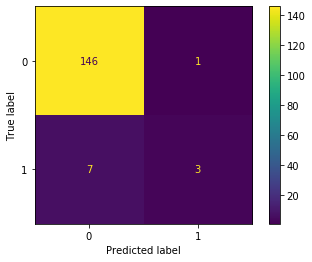

In [202]:
plot_confusion_matrix(clf_rf, X_valid, y_valid);

Much better than the decision tree overall, but still not great. The positive takeaway here is that the model is only getting one false positive, but it completely missed 7 out of the 10 total positives, hence the low recall score.

Let's see what features the model is highlighting by looking at a feature importance table. We can use this to compare it with our original decision tree to see how it might differ.

In [203]:
#display top 5 features from rf

var_imp = pd.DataFrame({"feature": X_train.columns, "importance": clf_rf.feature_importances_})
var_imp.sort_values(by = 'importance', ascending = False).head(5)

,feature,importance
6,12,0.073202
18,40,0.057209
37,97,0.051487
25,63,0.048190
7,13,0.043374


Some differences, but the top feature is the same in both the decision tree and random forest, as we might expect.

Next, we can try an SVM before finalizing a model. We should expect the SVM to perform fairly well on sparse data with class imbalance such as what we have. Let's see how it performs.

In [204]:
from sklearn.svm import SVC

svmc = SVC(C = 1.2, gamma = 'scale', kernel = 'rbf', class_weight = 'balanced')
svmc.fit(X_train, y_train)

y_hat_train_svm = svmc.predict(X_train)
y_hat_valid_svm = svmc.predict(X_valid)

acc_train_svm = accuracy_score(y_train, y_hat_train_svm)
acc_val_svm = accuracy_score(y_valid, y_hat_valid_svm)

print('Train set svm accuracy: {:.2f}%'.format(acc_train_svm * 100))
print('Validation set svm accuracy: {:.2f}%'.format(acc_val_svm * 100))

Train set svm accuracy: 99.66%
Validation set svm accuracy: 92.99%


The SVM performed slightly worse on accuracy than the Random Forest surprisingly. We can now check the precison and recall, check our models' performance on the test set, and then finalize an initial model.

In [205]:
precision_train_svm = precision_score(y_train, y_hat_train_svm, pos_label = 1) * 100
precision_valid_svm = precision_score(y_valid, y_hat_valid_svm, pos_label = 1) * 100
recall_train_svm = recall_score(y_train, y_hat_train_svm, pos_label = 1) * 100
recall_valid_svm = recall_score(y_valid, y_hat_valid_svm, pos_label = 1) * 100

print("Precision on training data: {:.1f}%".format(precision_train_svm))
print("Recall on training data: {:.1f}% \n".format(recall_train_svm))
print("Precision on validation data: {:.1f}%".format(precision_valid_svm))
print("Recall on validation data: {:.1f}%".format(recall_valid_svm))

Precision on training data: 99.3%
Recall on training data: 100.0% 

Precision on validation data: 46.2%
Recall on validation data: 60.0%


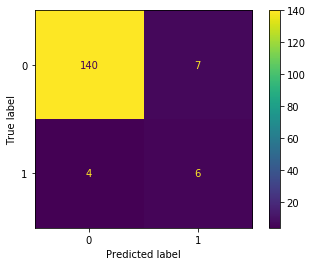

In [211]:
plot_confusion_matrix(svmc, X_valid, y_valid);

We are still faced with extreme overfitting due to class imbalance. The SVM performed worse than expected, underperforming the random forest on precision but scoring higher on recall. Let's now see how all three of our models perform on the test set.

In [207]:
y_dtree_test = dtree.predict(X_test)
y_rf_test = clf_rf.predict(X_test)
y_svm_test = svmc.predict(X_test) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.0s finished


In [208]:
acc_test_dtree = accuracy_score(y_test, y_dtree_test)
acc_test_rf = accuracy_score(y_test, y_rf_test)
acc_test_svm = accuracy_score(y_test, y_svm_test)

print('Test set decision tree accuracy: {:.2f}%'.format(acc_test_dtree * 100))
print('Test set random forest accuracy: {:.2f}%'.format(acc_test_rf * 100))
print('Test set support vector machine accuracy: {:.2f}%'.format(acc_test_svm * 100))

Test set decision tree accuracy: 73.25%
Test set random forest accuracy: 93.63%
Test set support vector machine accuracy: 90.45%


In [209]:
precision_test_dtree = precision_score(y_test, y_dtree_test, pos_label = 1) * 100
precision_test_rf = precision_score(y_test, y_rf_test, pos_label = 1) * 100
precision_test_svm = precision_score(y_test, y_svm_test, pos_label = 1) * 100

recall_test_dtree = recall_score(y_test, y_dtree_test, pos_label = 1) * 100
recall_test_rf = recall_score(y_test, y_rf_test, pos_label = 1) * 100
recall_test_svm = recall_score(y_test, y_svm_test, pos_label = 1) * 100

print("Decision tree test data precision: {:.1f}%".format(precision_test_dtree))
print("Decision tree test data recall: {:.1f}%".format(recall_test_dtree))
print("Random Forest test data precision: {:.1f}%".format(precision_test_rf))
print("Random Forest test data recall: {:.1f}%".format(recall_test_rf))
print("SVM test data precision: {:.1f}%".format(precision_test_svm))
print("SVM test data recall: {:.1f}%".format(recall_test_svm))

Decision tree test data precision: 5.6%
Decision tree test data recall: 20.0%
Random Forest test data precision: 50.0%
Random Forest test data recall: 10.0%
SVM test data precision: 14.3%
SVM test data recall: 10.0%


The random forest's performance from the validation set, dropped off but still handily outperformed the other two models. Having said that, the performance of our models on unseen data is still concerning. 

### Conclusion

As we wrap up phase 2, it is clear that there is still much work to be done to get a more robust, useful model. For this milestone, we can use the precision/recall scores on the test set above to make the conclusion that the random forest is the best performing model. It was able to generate the highest accuracy on each data set and was able to identify some of the positive cases more accurately than either of the other models (50% precision, 20% recall). 

The extreme class imbalance in this business case is a difficult problem to deal with. In our data set, faulty products make up less than 7% of the total manufactured. This is the reason our models are achieving high accuracy, but unable to score a high precision or recall.

With more time, we could have looked into creating a cost sensitive classifier that penalizes incorrect minority class decisions. It is also possible that our feature selection methodology of starting with mutual information classification and then using recursive feature elimination, may not be the optimal solution for this business case/data set. As we think about building our final model using a neural network in Milestone 3, we can reconsider these aspect if precision/recall is still an issue. The more powerful models that we build going forward may be able to better differentiate a faulty product from a normal one. 